In [1]:

import numpy as np
import random
import math


In [48]:
#  Simulated Annealing
# TODO: ADD ENDING WHERE WE START


# Distance matrix (10 stations with random distances)
# distance_matrix = np.random.randint(1, 100, size=(10, 10))
# np.fill_diagonal(distance_matrix, 0)

class TSP:
    def __init__(self, num_stations, min_max_distance=(1, 100), distance_matrix=None):

        if (num_stations and min_max_distance) is not None:
            self.distance_matrix = self.generate_distance_matrix(num_stations, min_max_distance)
        elif distance_matrix is not None:
            self.distance_matrix = distance_matrix
        else:
            raise ValueError("Please provide either num_stations and min_max_distance or a given distance matrix")
            
        self.current_route = np.random.permutation(self.distance_matrix.shape[0]) # Random intial route

        self.distances = [] # Tuples of (route, total distance of each route)


    def generate_distance_matrix(self, num_stations, min_max_distance):
        """
        Generate a random distance matrix for the given number of stations.
        distance_matrix[i, j] represents the distance from station i to station j
        """

        distance_matrix = np.random.randint(*min_max_distance, size=(num_stations, num_stations))
        np.fill_diagonal(distance_matrix, 0)
        return distance_matrix

    def swap_two_stations(self, route):
        """
        Swap two stations in the route to create a new route
        Works since each stop along the route is a station with an already implemented from - to
        """

        new_route = route.copy()
        i, j = random.sample(range(len(route)), 2) # Sample two stops along the route
        new_route[i], new_route[j] = new_route[j], new_route[i]

        # self.current_route = new_route
        return new_route

    def total_distance(self, route, end_at_start=False):
        """
        Calculate the total distance of the given route
        For each stop, calculate the distance from previous stop to that stop
        """
        
        dist = 0
        for i in range(len(route) - 1):
            dist += self.distance_matrix[route[i], route[i + 1]]
        
        if end_at_start:
            dist += self.distance_matrix[route[-1], route[0]]
        
        return dist

    def simulated_annealing(self, max_iterations):
        """Perform Simulated Annealing to solve the TSP."""
        # Initialize the current state
        # num_stations = distance_matrix.shape[0]
        # current_route = list(range(num_stations))
        # random.shuffle(current_route)

        # TODO: REMOVE self.current route and just use as regular argumnet, no reason to have it frr
        current_route = self.current_route
        current_distance = self.total_distance(self.current_route)

        best_route = self.current_route
        best_distance = current_distance
        
        # temp = initial_temp # CAn perhaps setp initial temp?
        
        for k in range(max_iterations):
            temp = 1 / math.sqrt(1 + k)
            is_improvement = False

            # NEed this? Does temp ever go that fucking low?
            # if temp < 1e-8:
            #     break

            new_route = self.swap_two_stations(current_route)
            new_distance = self.total_distance(new_route, end_at_start=True)
            
            if new_distance < current_distance:
                current_route = new_route
                current_distance = new_distance
            else:
                acceptance_prob = math.exp(-(new_distance - current_distance) / temp)
                if random.random() < acceptance_prob:
                    current_route = new_route
                    current_distance = new_distance
                    
            if current_distance < best_distance:
                best_route = current_route
                best_distance = current_distance
                is_improvement = True
                
            self.distances.append([k, current_route, current_distance, is_improvement])

            # print(f"Iteration {k}, Temperature: {temp:.4f}, Current Distance: {current_distance}, Best Distance: {best_distance}")
        
        return best_route, best_distance


In [55]:
# Running

# Parameters
max_iterations = 200
# num_stations = 20
# min_max_distance = (1, 100)

# Resetting the distance matrix to be another
distance_matrix = np.genfromtxt('cost.csv', delimiter=',')

# Running the simulated annealing algorithm
annealing_tsp = TSP(num_stations=None, min_max_distance=None, distance_matrix=distance_matrix)

best_route, best_distance = annealing_tsp.simulated_annealing(max_iterations)

# TODO: Add some stats about the best route and such based on the distances list

print("Best route found:", best_route)
print("Distance of the best route:", best_distance)


Best route found: [13  1  8 15  9  4  7  6 16  3 11  0  5 12  2 10 17 19 14 18]
Distance of the best route: 991.0


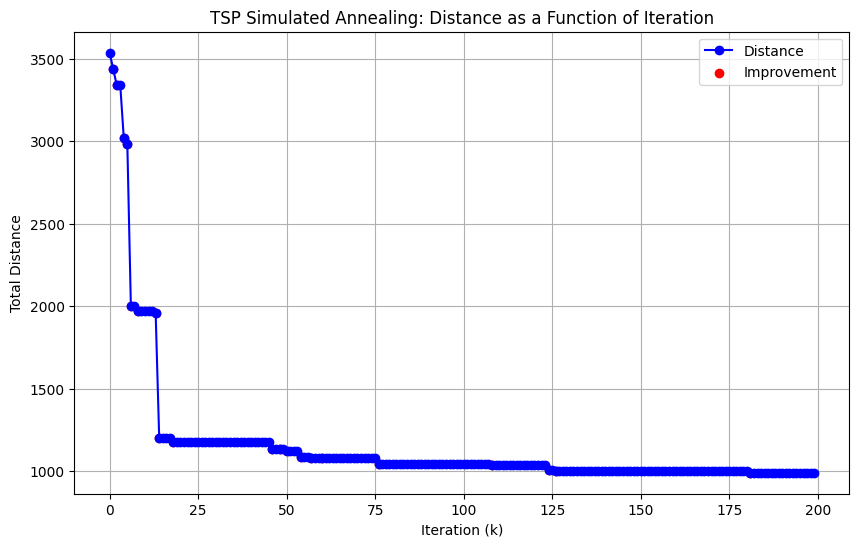

In [56]:
import matplotlib.pyplot as plt

# Assuming `annealing_tsp.distances` contains tuples of (k, current_route, distance, is_improvement)
# Generate some dummy data for testing

distances = annealing_tsp.distances

# Extract data
ks = [entry[0] for entry in distances]
dists = [entry[2] for entry in distances]
improvements = [entry[3] for entry in distances]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(ks, dists, label='Distance', color='blue', marker='o')

# Highlight improvements
improved_ks = [ks[i] for i in range(len(ks)) if improvements[i]]
improved_dists = [dists[i] for i in range(len(dists)) if improvements[i]]

plt.scatter(improved_ks, improved_dists, color='red', label='Improvement')

plt.xlabel('Iteration (k)')
plt.ylabel('Total Distance')
plt.title('TSP Simulated Annealing: Distance as a Function of Iteration')
plt.legend()
plt.grid(True)
plt.show()


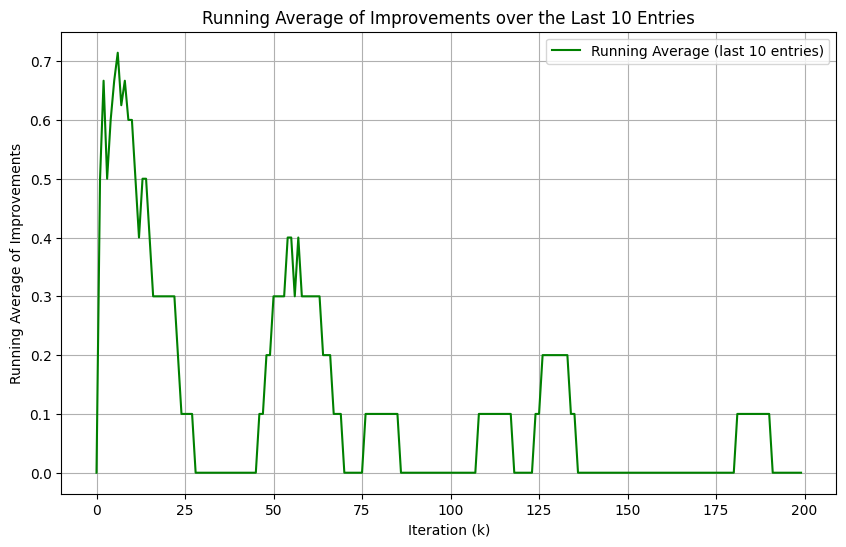

In [57]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_running_average(improvements, p):
    running_avg = []
    for i in range(len(improvements)):
        if i < p:
            # Calculate the average of the first `i+1` elements if we don't have `p` elements yet
            avg = np.mean(improvements[:i+1])
        else:
            # Calculate the average of the last `p` elements
            avg = np.mean(improvements[i-p+1:i+1])
        running_avg.append(avg)
    return running_avg

# Assuming `annealing_tsp.distances` contains tuples of (k, current_route, distance, is_improvement)
distances = annealing_tsp.distances

# Extract data
ks = [entry[0] for entry in distances]
improvements = [entry[3] for entry in distances]

# Parameters
p = 10  # Set the value of `p` as needed

# Calculate running averages
running_avg_improvements = calculate_running_average(improvements, p)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(ks, running_avg_improvements, label=f'Running Average (last {p} entries)', color='green')

plt.xlabel('Iteration (k)')
plt.ylabel('Running Average of Improvements')
plt.title(f'Running Average of Improvements over the Last {p} Entries')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
import numpy as np

def create_tsp_matrix(num_stations):
    # Initialize a matrix with high values representing "infinity" for initial distances
    infinity = float(100)
    matrix = np.full((num_stations, num_stations), infinity)
    
    # Fill the matrix according to the circular shortest path rule
    for i in range(num_stations):
        matrix[i, (i + 1) % num_stations] = 1  # Distance to the next station in the circle
        matrix[i, (i - 1) % num_stations] = 1  # Distance to the previous station in the circle
        
    return matrix

# Example usage
num_stations = 10
tsp_matrix = create_tsp_matrix(num_stations)
print(tsp_matrix)


[[100.   1. 100. 100. 100. 100. 100. 100. 100.   1.]
 [  1. 100.   1. 100. 100. 100. 100. 100. 100. 100.]
 [100.   1. 100.   1. 100. 100. 100. 100. 100. 100.]
 [100. 100.   1. 100.   1. 100. 100. 100. 100. 100.]
 [100. 100. 100.   1. 100.   1. 100. 100. 100. 100.]
 [100. 100. 100. 100.   1. 100.   1. 100. 100. 100.]
 [100. 100. 100. 100. 100.   1. 100.   1. 100. 100.]
 [100. 100. 100. 100. 100. 100.   1. 100.   1. 100.]
 [100. 100. 100. 100. 100. 100. 100.   1. 100.   1.]
 [  1. 100. 100. 100. 100. 100. 100. 100.   1. 100.]]
